# Fetch dataset
I will be working with COCO Captions, which is a large-scale object detection, segmentation, and captioning dataset. It contains over 330k images, with more than 200k labeled images.

In [1]:
import tqdm
%pip install loguru
from loguru import logger
import sys
import torch
# allow all messages
logger.remove()
logger_id = logger.add(sys.stderr, level="TRACE", colorize=True, format="<level>{level}</level>: {message} | {name}:{function}:{line} | {time:HH:mm:ss DD-MM-YYYY}")
IN_COLAB = 'google.colab' in sys.modules
logger.info("Colab? : {}", IN_COLAB)
if IN_COLAB:
  logger.info("Mounitng Google drive")
  from google.colab import drive
  drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info("Running on {}", device)
%env KAGGLEHUB_CACHE=datasets
import kagglehub
import os
logger.info("Importing dataset to {}", os.environ["KAGGLEHUB_CACHE"])
path = kagglehub.dataset_download("nikhil7280/coco-image-caption")
logger.info("Path to dataset files:", path)
import sys


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 2.2 MB/s eta 0:00:00


INFO: Colab? : True | __main__:<cell line: 0>:10 | 07:27:22 30-03-2025
INFO: Mounitng Google drive | __main__:<cell line: 0>:12 | 07:27:22 30-03-2025
INFO: Running on cuda | __main__:<cell line: 0>:16 | 07:27:45 30-03-2025


Mounted at /content/drive
env: KAGGLEHUB_CACHE=datasets


INFO: Importing dataset to datasets | __main__:<cell line: 0>:20 | 07:27:45 30-03-2025


100%|██████████| 13.7G/13.7G [01:29<00:00, 165MB/s]

Extracting files...



INFO: Path to dataset files: | __main__:<cell line: 0>:22 | 07:30:26 30-03-2025


In [2]:
from torch.utils.data import Dataset
import json
class CaptionDataset(Dataset):
    def __init__(self, images_dir: str, json_path: str, transform=None):
        logger.trace("Initializing CaptionDataset, with images_dir: {}, json_path: {}", images_dir, json_path)
        self.images_dir = images_dir
        self.transform = transform
        annotations = json.load(open(json_path, 'r'))
        self.img_paths = {}
        self.img_cache = {}
        logger.trace("Loading annotations from {}", json_path)
        logger.trace("Loading images")
        for imgdata in annotations['images']:
            id = imgdata['id']
            path = os.path.join(self.images_dir, imgdata['file_name'])
            self.img_paths[id] = path
        logger.info("Loaded {} images", len(self.img_paths))
        logger.trace("Loading captions")
        self.captions = []
        self.image_to_caption = {}
        for imgdata in annotations['annotations']:
            id = imgdata['image_id']
            caption = imgdata['caption']
            assert len(caption) > 0, "Caption is empty"
            assert id in self.img_paths, "Image ID not found in img_paths"
            self.captions.append((self.img_paths[id], caption))
            inserted_index = len(self.captions) - 1
            if id not in self.image_to_caption:
                self.image_to_caption[id] = []
            self.image_to_caption[id].append(inserted_index)
        logger.trace("Loaded {} captions", len(self.captions))

    def __getitem__(self, index):
        img_path, caption = self.captions[index]
        return self.load_image(img_path), caption

    def __len__(self):
        return len(self.captions)

    def load_image(self, img_path):
        logger.trace("Loading image from {}", img_path)
        if img_path in self.img_cache:
            logger.trace("Image found in cache")
            return self.img_cache[img_path]
        else:
            logger.trace("Image not found in cache, loading from disk")
            img = Image.open(img_path).convert('RGB')
            if self.transform is not None:
                img = self.transform(img)
            self.img_cache[img_path] = img
            return img


In [3]:
from PIL import Image
from torchvision.transforms import v2
import random
import os
transform = v2.Compose([
        v2.Resize((224, 224)),
        #v2.RandomCrop((224, 224), pad_if_needed=True, padding_mode='symmetric'),
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

dataset = CaptionDataset(
    images_dir=os.path.join(path, 'train2014/train2014'),
    json_path=os.path.join(path, 'annotations_trainval2014/annotations/captions_train2014.json')
)
id = dataset.img_paths.keys().__iter__().__next__()
print(dataset.img_paths.get(id))
print(dataset.image_to_caption.get(id))

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
TRACE: Initializing CaptionDataset, with images_dir: datasets/datasets/nikhil7280/coco-image-caption/versions/1/train2014/train2014, json_path: datasets/datasets/nikhil7280/coco-image-caption/versions/1/annotations_trainval2014/annotations/captions_train2014.json | __main__:__init__:5 | 07:30:32 30-03-2025
TRACE: Loading annotations from datasets/datasets/nikhil7280/coco-image-caption/versions/1/annotations_trainval2014/annotations/captions_train2014.json | __main__:__init__:11 | 07:30:33 30-03-2025
TRACE: Loading images | __main__:__init__:12 | 07:30:33 30-03-2025
INFO: Loaded 82783 images | __main__:__init__:17 | 07:30:33 30-03-2025
TRACE: Loading captions | __

datasets/datasets/nikhil7280/coco-image-caption/versions/1/train2014/train2014/COCO_train2014_000000057870.jpg
[30990, 31048, 31071, 31129, 31282]


In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Config, AutoTokenizer

class TransformerDecoderWithCrossAttention(nn.Module):
    def __init__(self, embedding_dim, vocab_size, max_length, gpt2_model_name='gpt2'):
        super(TransformerDecoderWithCrossAttention, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.max_length = max_length

        # Load GPT-2 configuration
        gpt2_config = GPT2Config.from_pretrained(gpt2_model_name)
        self.hidden_dim = gpt2_config.n_embd
        self.num_heads = gpt2_config.n_head

        # Linear layer to project image embeddings into GPT-2 embedding space
        self.image_projection = nn.Linear(embedding_dim, self.hidden_dim)

        # Load pre-trained GPT-2 model
        self.gpt2 = GPT2LMHeadModel.from_pretrained(gpt2_model_name)

        # Freeze GPT-2 parameters (optional, can be fine-tuned later)
        #for param in self.gpt2.parameters():
        #    param.requires_grad = False

        # Add cross-attention layers to each GPT-2 transformer block
        for layer in self.gpt2.transformer.h:
            layer.cross_attention = nn.MultiheadAttention(
                self.hidden_dim, self.num_heads, batch_first=True)

        # Learnable positional embeddings for image input
        self.image_positional_embedding = nn.Parameter(torch.randn(1, 1, self.hidden_dim))

    def forward(self, image_embeddings, target_tokens=None, attention_mask=None):
        batch_size = image_embeddings.size(0)

        # Project image embeddings into GPT-2 embedding space
        projected_image_embeddings = self.image_projection(image_embeddings) + self.image_positional_embedding

        if target_tokens is not None:
            # Prepare input tokens (prepend BOS token)
            start_tokens = torch.ones((batch_size, 1), dtype=torch.long, device=image_embeddings.device) * self.gpt2.config.bos_token_id
            input_tokens = torch.cat([start_tokens, target_tokens], dim=1)
            input_embeddings = self.gpt2.transformer.wte(input_tokens)

            # Create attention mask (1 for valid tokens, 0 for padding)
            if attention_mask is None:
                pad_token_id = self.gpt2.config.pad_token_id or 0  # Default to 0 if pad_token_id is None
                attention_mask = (input_tokens != pad_token_id).long()

            # Create causal mask to prevent future token access
            seq_length = input_tokens.size(1)
            causal_mask = torch.tril(torch.ones(seq_length, seq_length, device=image_embeddings.device)).unsqueeze(0).unsqueeze(0)

            # Process each transformer block
            for layer in self.gpt2.transformer.h:
                # Self-attention
                attn_output, _ = layer.attn(hidden_states=input_embeddings, attention_mask=causal_mask)

                # Cross-attention (image embeddings as key/value)
                cross_attn_output, _ = layer.cross_attention(attn_output, projected_image_embeddings, projected_image_embeddings)

                # Residual connections
                input_embeddings = input_embeddings + attn_output + cross_attn_output
                input_embeddings = input_embeddings.contiguous()

            # Get final logits
            outputs = self.gpt2(inputs_embeds=input_embeddings, attention_mask=attention_mask, use_cache=False)
            logits = outputs.logits[:, :-1, :]
            return logits
        else:
            # Autoregressive inference (generation mode)
            generated_tokens = torch.ones((batch_size, 1), dtype=torch.long, device=image_embeddings.device) * self.gpt2.config.bos_token_id
            all_generated_tokens = generated_tokens
            input_embeddings = self.gpt2.transformer.wte(generated_tokens)

            for _ in range(self.max_length):
                seq_length = input_embeddings.size(1)
                causal_mask = torch.tril(torch.ones(seq_length, seq_length, device=image_embeddings.device)).unsqueeze(0).unsqueeze(0)

                for layer in self.gpt2.transformer.h:
                    attn_output, _ = layer.attn(hidden_states=input_embeddings, attention_mask=causal_mask)
                    cross_attn_output, _ = layer.cross_attention(attn_output, projected_image_embeddings, projected_image_embeddings)
                    input_embeddings = input_embeddings + attn_output + cross_attn_output
                    input_embeddings = input_embeddings.contiguous()

                outputs = self.gpt2(inputs_embeds=input_embeddings, use_cache=False)
                logits = outputs.logits[:, -1, :]
                predicted_token = torch.argmax(logits, dim=-1).unsqueeze(1)

                if predicted_token.item() == self.gpt2.config.eos_token_id:
                    break

                all_generated_tokens = torch.cat([all_generated_tokens, predicted_token], dim=1)
                input_embeddings = self.gpt2.transformer.wte(predicted_token)

            return all_generated_tokens[:, 1:]


In [59]:
from transformers import ViTModel
from PIL import Image
class HandmadeEncoderDecoder(nn.Module):
    def __init__(self):
        super(HandmadeEncoderDecoder, self).__init__()
        ENCODER_CHEKCPOINT = "google/vit-base-patch16-224-in21k" # use the pre-trained ViT model for now
        self.encoder = ViTModel.from_pretrained(ENCODER_CHEKCPOINT)
        self.embedding_dim = self.encoder.config.hidden_size # the hidden size of the encoder is the size of the image embeddings generated, without any specific head, it should be a representation of the image
        self.tokenizer = AutoTokenizer.from_pretrained("gpt2")# I don't know much about the tokenizer, but we need it here for the vocab size, so the decoder knows the lenth of the *thing* which returns the probability of then next token
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.tokenizer.pad_token_id = self.tokenizer.eos_token_id
        self.vocab_size = self.tokenizer.vocab_size
        self.max_length = 20 # the maximum length of the caption, this is a hyperparameter, we can change it later
        self.decoder = TransformerDecoderWithCrossAttention(self.embedding_dim, self.vocab_size, self.max_length)
        logger.trace("HandmadeEncoderDecoder initialized with embedding_dim: {}, vocab_size: {}, max_length: {}", self.embedding_dim, self.vocab_size, self.max_length)

    def forward(self, image: Image.Image, target_tokens=None):
        '''
            target_tokens - used for training, represents the caption so far and because the model is autoregressive, we need to pass the previous tokens to get the next token
            image - the image to be encoded, shape (batch_size, 3, 224, 224)
        '''
        batch_size = image.size(0)
        encoder_output = self.encoder(image).last_hidden_state.mean(dim=1).unsqueeze(1)
        #print(f'image shape: {image.shape}, encoder_output shape: {encoder_output.shape}, target_tokens shape: {target_tokens.shape if target_tokens is not None else None}')
        decoder_output = self.decoder(encoder_output, target_tokens)
        if target_tokens is not None:
            return decoder_output
        else:
            return self.tokenizer.batch_decode(decoder_output.cpu().tolist(), skip_special_tokens=True)


In [60]:
model = HandmadeEncoderDecoder().to(device)

In [46]:
from torch.utils.data import DataLoader, Subset
# Create dataset and dataloader
dataset_train = CaptionDataset(
    images_dir=os.path.join(path, 'train2014/train2014'),
    json_path=os.path.join(path, 'annotations_trainval2014/annotations/captions_train2014.json'),
    transform=transform
)
dataset_train = Subset(dataset_train, random.sample(range(len(dataset_train)), 10)) # use only 1000 samples for training
dataloader = DataLoader(dataset_train, batch_size=5, shuffle=True)

In [61]:
from torch.optim import Adam
import tqdm
torch.autograd.set_detect_anomaly(True)
def train_model(model, train_dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    tokenizer = model.tokenizer
    tokenizer.pad_token = tokenizer.eos_token
    pbar = tqdm.tqdm(train_dataloader, desc="Training", leave=False)
    for images, captions in pbar:
        images = images.to(device)

        tokenized_captions = tokenizer(captions, return_tensors="pt", padding=True, truncation=True, max_length=model.max_length).input_ids.squeeze(0)
        target_tokens = tokenized_captions.to(device)

        optimizer.zero_grad()
        logits = model(images, target_tokens)
        shift_logits = logits[:, :-1, :].contiguous().view(-1, logits.size(-1))
        shift_labels = target_tokens[:, 1:].contiguous().view(-1)  # Shift left by 1

        loss = criterion(shift_logits, shift_labels)
        pbar.set_postfix(loss=loss)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_dataloader)

# Define optimizer and loss function
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=model.tokenizer.pad_token_id)

In [75]:
logger.remove(logger_id)
logger_id = logger.add(sys.stderr, level="WARNING", colorize=True, format="<level>{level}</level>: {message} | {name}:{function}:{line} | {time:HH:mm:ss DD-MM-YYYY}")
from torch.nn.attention import SDPBackend, sdpa_kernel
# Training loop
num_epochs = 1000
with sdpa_kernel(SDPBackend.MATH):
  for epoch in range(num_epochs):
      train_loss = train_model(model, dataloader, optimizer, criterion, device)
      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}')

Epoch 1/1000, Train Loss: 3.9470


Epoch 2/1000, Train Loss: 3.9344


Epoch 3/1000, Train Loss: 3.9393


Epoch 4/1000, Train Loss: 3.9594


Epoch 5/1000, Train Loss: 3.9488


Epoch 6/1000, Train Loss: 3.9387


Epoch 7/1000, Train Loss: 3.9558


Epoch 8/1000, Train Loss: 3.9673


KeyboardInterrupt: 

In [39]:
# Save the trained model
import shutil
torch.save(model.state_dict(), 'trained_model.pth')
if IN_COLAB:
  shutil.copy("trained_model.pth","/content/drive/MyDrive/encoder-autoregressivedecoder")

[' a a a a a a a a a a a a a a a a a a a a']


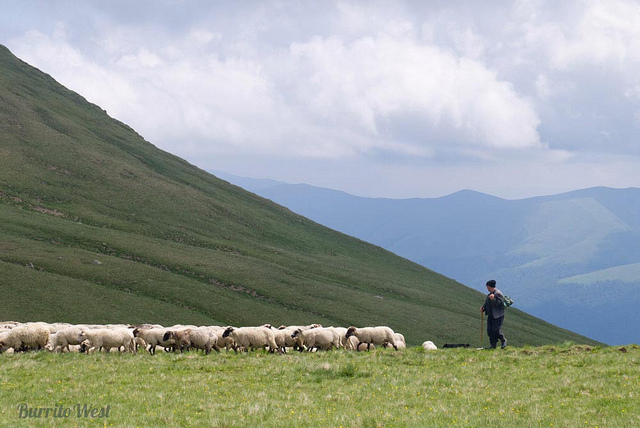

In [73]:
model.eval()
with torch.no_grad():
    img, caption = dataset[random.randint(0, len(dataset.captions)-1)]
    img_pixel_values = transform(img).unsqueeze(0)
    img_pixel_values = img_pixel_values.to(device)
    generated_caption = model(image=img_pixel_values,target_tokens=None)
    print(generated_caption)
img